<a href="https://colab.research.google.com/github/louistrue/learn-ifc-bfh25-D/blob/main/BFH-25-IFC-Dashboard-Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# IFC Dashboard Starter Template

A minimal template to get started building IFC data dashboards.

**What this does:**
- Load an IFC file from GitHub
- Extract element types and building storeys
- Create a simple 2-tab dashboard


## Step 1: Install packages


In [2]:
%pip install -q ifcopenshell pandas plotly dash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 125.9 MB/s eta 0:00:00


## Step 2: Load IFC file from GitHub


In [3]:
import urllib.request
import ifcopenshell

# Download IFC file from GitHub
github_url = 'https://raw.githubusercontent.com/louistrue/learn-ifc-bfh25-D/refs/heads/main/%C3%9Cbung_fire_rating/02_BIMcollab_Example_ARC.ifc'
local_filename = '02_BIMcollab_Example_ARC.ifc'

print("📥 Downloading IFC file...")
urllib.request.urlretrieve(github_url, local_filename)
print("✅ Downloaded successfully!")

# Open IFC file
model = ifcopenshell.open(local_filename)
print(f"\n🏗️ Loaded: {model.schema}")
print(f"📊 Total elements: {len(model.by_type('IfcElement'))}")


📥 Downloading IFC file...
✅ Downloaded successfully!

🏗️ Loaded: IFC2X3
📊 Total elements: 1354


## Step 3: Parse IFC data

Extract elements and their building storeys.


In [20]:
import ifcopenshell.util.element as uel
import pandas as pd

element_data = []

for element in model.by_type('IfcElement'):
    element_id = element.GlobalId
    element_type = element.is_a()
    element_name = getattr(element, 'Name', None) or 'Unnamed'

    # Property Sets extrahieren
    psets = uel.get_psets(element)

    # Nach Fire Rating Property suchen
    fire_rating = None
    for pset_name, properties in psets.items():
        # Suche nach verschiedenen Property-Namen für Fire Rating
        possible_names = ['FireRating', 'fire_rating', 'FireRatingName', 'FireResistance']
        for prop_name, prop_value in properties.items():
            if prop_name in possible_names:
                fire_rating = prop_value
                break
        if fire_rating:
            break

    # Finde Geschoss
    storey = 'Not assigned'
    for rel in model.by_type('IfcRelContainedInSpatialStructure'):
        if element in rel.RelatedElements:
            if rel.RelatingStructure and rel.RelatingStructure.is_a('IfcBuildingStorey'):
                storey = rel.RelatingStructure.LongName or rel.RelatingStructure.Name
                break

    element_data.append({
        'ElementId': element_id,
        'ElementType': element_type,
        'ElementName': element_name,
        'FireRating': fire_rating or 'Nicht klassifiziert',
        'Storey': storey
    })

df = pd.DataFrame(element_data)

print(f"✅ Parsed {len(df)} element records")
print(f"🏢 Found {df['Storey'].nunique()} storeys")
print(f"🔧 Found {df['ElementType'].nunique()} element types")

df.head()

✅ Parsed 1354 element records
🏢 Found 6 storeys
🔧 Found 16 element types


,ElementId,ElementType,ElementName,FireRating,Storey
0,11EjrZoVgVGQm8NAB8Ffig,IfcBeam,Beam rafter,R 90,03 Roof
1,0lGOlmpSwhJPOckuTSPXZB,IfcBeam,Beam rafter,R 90,03 Roof
2,11jlLCAS12JO84wxBdhra4,IfcBeam,Beam rafter,R 90,03 Roof
3,21k7FMrZHwGvPQkn_$aUzo,IfcBeam,Beam rafter,R 90,03 Roof
4,27OrqS3cNtHeNPRKPxu6dq,IfcBeam,Beam rafter,R 90,03 Roof


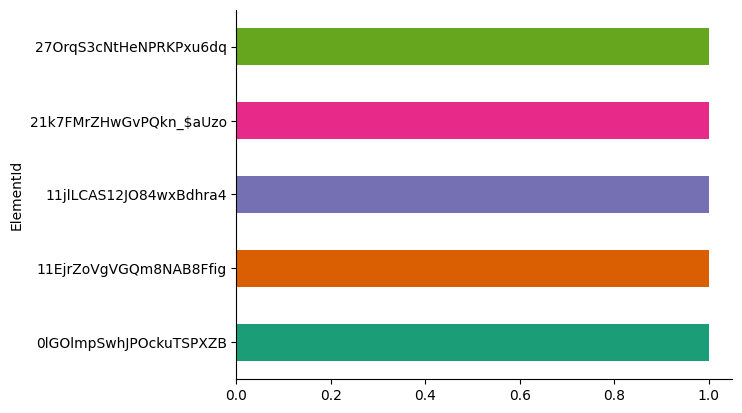

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('ElementId').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

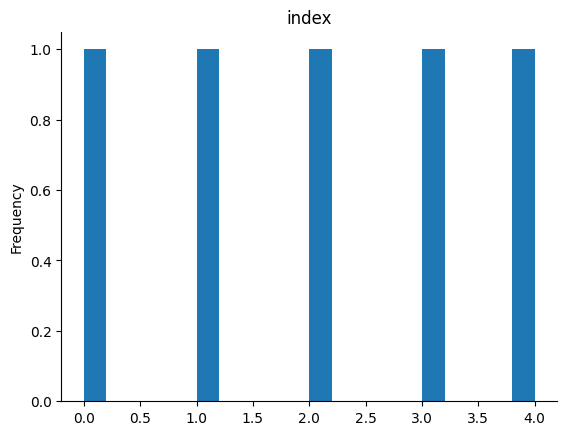

In [22]:
from matplotlib import pyplot as plt
_df_4['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Step 4: Create aggregations for visualization


In [27]:
# Fire Rating Verteilung
fire_rating_counts = (
    df.groupby('FireRating')['ElementId']
    .nunique()
    .reset_index(name='Count')
    .sort_values('Count', ascending=False)
)

# Fire Rating nach Elementtyp
fire_rating_by_type = (
    df.groupby(['FireRating', 'ElementType'])['ElementId']
    .nunique()
    .reset_index(name='Count')
    .sort_values('Count', ascending=False)
)

# Fire Rating nach Geschoss
fire_rating_by_storey = (
    df.groupby(['FireRating', 'Storey'])['ElementId']
    .nunique()
    .reset_index(name='Count')
    .sort_values('Count', ascending=False)
)


'https://raw.githubusercontent.com/louistrue/learn-ifc-bfh25-D/refs/heads/main/%C3%9Cbung_fire_rating/02_BIMcollab_Example_ARC.ifc'


print("📊 Data ready for visualization!")
display(fire_rating_counts.head())
display(fire_rating_by_type.head())


📊 Data ready for visualization!


,FireRating,Count
0,30,699
3,Nicht klassifiziert,277
6,REI 60,180
2,EW 30,71
1,EI2 60-C5-S200,57


,FireRating,ElementType,Count
1,30,IfcCurtainWall,614
17,REI 60,IfcWall,171
0,30,IfcCovering,85
8,Nicht klassifiziert,IfcFooting,75
3,EW 30,IfcWindow,71


## Step 5: Build a simple dashboard


In [32]:
from dash import Dash, dcc, html
import plotly.express as px

app = Dash(__name__)

# Diagramme erstellen
# Note: These plots depend on aggregated dataframes that might not be available
# if the 'FireRating' column was not successfully extracted.
# Assuming fire_rating_counts, fire_rating_by_type, and fire_rating_by_storey
# are available from previous steps.

# Check if required dataframes exist before creating plots
# This is a safeguard in case the previous cell had issues
required_dfs = ['fire_rating_counts', 'fire_rating_by_type', 'fire_rating_by_storey', 'fire_heatmap_data']
for df_name in required_dfs:
    if df_name not in globals():
        print(f"Warning: DataFrame '{df_name}' not found. Skipping related plots.")


# Only create plots if the required dataframes exist
fig_fire_overview = None
if 'fire_rating_counts' in globals():
    fig_fire_overview = px.bar(
        fire_rating_counts,
        x='FireRating',
        y='Count',
        title='Fire Rating Verteilung',
        text_auto='.0f'
    )

fig_fire_by_type = None
if 'fire_rating_by_type' in globals():
    fig_fire_by_type = px.bar(
        fire_rating_by_type,
        x='ElementType',
        y='Count',
        color='FireRating',
        title='Fire Rating nach Elementtyp'
    )

fig_fire_by_storey = None
if 'fire_rating_by_storey' in globals():
    fig_fire_by_storey = px.bar(
        fire_rating_by_storey,
        x='Storey',
        y='Count',
        color='FireRating',
        title='Fire Rating nach Geschoss'
    )

# Heatmap
fig_heatmap = None
if 'fire_heatmap_data' in globals():
    fig_heatmap = px.density_heatmap(
        fire_heatmap_data, # Use the aggregated data here
        x='ElementType',
        y='FireRating',
        z='Count',
        title='Fire Rating vs Elementtyp',
        color_continuous_scale='Viridis'
    )


app.layout = html.Div([
    html.H1('Fire Rating Dashboard'),
    html.P('Brandschutzklassifikation der Gebäudeelemente'),

    dcc.Tabs([
        dcc.Tab(label='Übersicht', children=[
            html.H3('Gesamtverteilung'),
            dcc.Graph(figure=fig_fire_overview) if fig_fire_overview else html.P("Data not available for this plot.")
        ]),
        dcc.Tab(label='Nach Elementtyp', children=[
            html.H3('Fire Rating nach Bauteiltyp'),
            dcc.Graph(figure=fig_fire_by_type) if fig_fire_by_type else html.P("Data not available for this plot.")
        ]),
        dcc.Tab(label='Nach Geschoss', children=[
            html.H3('Fire Rating pro Geschoss'),
            dcc.Graph(figure=fig_fire_by_storey) if fig_fire_by_storey else html.P("Data not available for this plot.")
        ]),
        dcc.Tab(label='Heatmap', children=[
            html.H3('Fire Rating Heatmap'),
            dcc.Graph(figure=fig_heatmap) if fig_heatmap else html.P("Data not available for this plot.")
        ])
    ])
])

# Run the dashboard
print("🚀 Starting dashboard...")
app.run(jupyter_mode='inline', height=700, port=8050)

🚀 Starting dashboard...


<IPython.core.display.Javascript object>

## Next Steps

**Extend this template:**
- Add more tabs for different analyses
- Include materials data
- Add filters with dropdowns
- Try different chart types

**Try other files:**
- Change the `github_url` to load different IFC files
- Upload your own IFC files using file upload widgets

**Learn more:**
- [IFCOpenShell Documentation](https://docs.ifcopenshell.org/)
- [Plotly Dash Documentation](https://dash.plotly.com/)
- [Full example: BFH-25-Tabbed-Dashboard.ipynb](https://github.com/louistrue/learn-ifc-bfh25-D/blob/main/BFH-25-Tabbed-Dashboard.ipynb)
